# Compare Hankel and Fourier Transforms

This will compare the forward and inverse transforms for both Hankel and Fourier by either computing partial derivatives of solving a parital differential equation.

This notebook focuses on the Laplacian operator in the case of radial symmetry. 

Consider two 2D circularly-symmetric functions $f(r)$ and $g(r)$ that are related by the following differential operator,
$$
g(r) = \nabla^2 f(r) 
= \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial f}{\partial r} \right)
$$
In this notebook we will consider two problems:
1. Given $f(r)$, compute the Laplacian to obtain $g(r)$
2. Given $g(r)$, invert the Laplacian to obtain $f(r)$

We can use the 1D Hankel (or 2D Fourier) transform to compute the Laplacian in three steps:
1. Compute the Forward Transform
    $$
    \mathcal{H}[f(r)] = \hat f(k)
    $$
2. Differentiate in Spectral space
    $$
    \hat g(k) = - k^2 \hat f(k)
    $$
3. Compute the Inverse Transform
    $$
    g(r) = \mathcal{H}^{-1} [\hat g(k)]
    $$
    
This is easily done in two-dimensions using the Fast Fourier Transform (FFT) but one advantage of the Hankel transform is that we only have a one-dimensional transform.

## Import Relevant Libraries

In [1]:
# Import Libraries

import numpy as np                                                        # Numpy
from scipy.fftpack import fft2, ifft2, fftfreq, ifftn, fftn               # Fourier
from hankel import HankelTransform, SymmetricFourierTransform             # Hankel
from scipy.interpolate import InterpolatedUnivariateSpline as spline      # Splines
import matplotlib.pyplot as plt                                           # Plotting
import matplotlib as mpl
from os import path
%matplotlib inline

In [15]:
## Put the prefix to the figure directory here for your computer. If you don't want to save files, set to empty string, or None.
prefix = "/home/steven/Documents/Projects/HANKEL/laplacian_paper/Figures/"

## Standard Plot Aesthetics

In [3]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.titlesize'] = 14

## Define Sample Functions

We define the two functions
$$
f = e^{-r^2}
\quad \mbox{ and } \quad
g = 4 e^{-r^2} (r^2 - 1).
$$
It is easy to verify that they are related by the Laplacian operator.

In [4]:
# Define Gaussian

f = lambda r: np.exp(-r**2)

# Define Laplacian Gaussian function

g = lambda r: 4.0*np.exp(-r**2)*(r**2 - 1.0)

We can also define the FTs of these functions analytically, so we can compare our numerical results:

In [6]:
fhat = lambda x : np.pi*np.exp(-x**2/4.)
ghat = lambda x : -x**2*fhat(x)

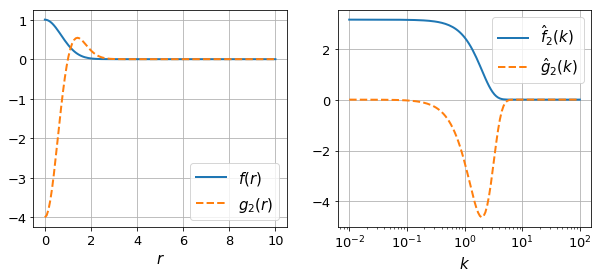

In [33]:
# Make a plot of the sample functions

fig, ax = plt.subplots(1,2,figsize=(10,4))
r = np.linspace(0,10,128)
ax[0].plot(r, f(r), label=r"$f(r)$")
ax[0].plot(r, g(r), label=r'$g_2(r)$', ls="--")
ax[0].legend()
ax[0].set_xlabel(r"$r$")
ax[0].grid(True)

k = np.logspace(-2,2,128)
ax[1].plot(k, fhat(k), label=r"$\hat{f}_2(k)$")
ax[1].plot(k, ghat(k), label=r'$\hat{g}_2(k)$', ls="--")
ax[1].legend()
ax[1].set_xlabel(r"$k$")
ax[1].grid(True)
ax[1].set_xscale('log')
#plt.suptitle("Plot of Sample Functions")


if prefix:
    plt.savefig(path.join(prefix,"sample_function.pdf"))

## Define Transformation Functions

In [10]:
def ft_transformation_2d(f,x, inverse=False):

    xx,yy = np.meshgrid(x,x)
    r = np.sqrt(xx**2 + yy**2)
    
    # Appropriate k-space values
    k = 2*np.pi*fftfreq(len(x),d=x[1]-x[0])
    kx,ky = np.meshgrid(k,k)
    K2 = kx**2+ky**2
    
    # The transformation
    if not inverse:
        g2d = ifft2(-K2 * fft2(f(r)).real).real
    else:
        invK2 = 1./K2
        invK2[np.isinf(invK2)] = 0.0
        
        g2d = ifft2(-invK2 * fft2(f(r)).real).real
        
    return x[len(x)/2:], g2d[len(x)/2,len(x)/2:]

In [11]:
def ht_transformation_nd(f,N_forward,h_forward,K,r,ndim=2, inverse=False, N_back=None, h_back=None, 
                         ret_everything=False):
    
    if N_back is None:
        N_back = N_forward
    if h_back is None:
        h_back = h_forward
        
    # Get transform of f
    ht = SymmetricFourierTransform(ndim=ndim, N=N_forward, h=h_forward)
    
    if ret_everything:
        fhat, fhat_cumsum = ht.transform(f, K, ret_cumsum=True, ret_err=False)
    else:
        fhat = ht.transform(f, K, ret_err = False)
    
    # Spectral derivative
    if not inverse:
        ghat = -K**2 * fhat
    else:
        ghat = -1./K**2 * fhat
        
    # Transform back to physical space via spline
    # The following should give best resulting splines for most kinds of functions
    # Use log-space y if ghat is either all negative or all positive, otherwise linear-space
    # Use order 1 because if we have to extrapolate, this is more stable.
    # This will not be a good approximation for discontinuous functions... but they shouldn't arise.
    if np.all(ghat<=1e-13):
        g_ = spline(K[ghat<0],np.log(-ghat[ghat<0]),k=1)
        ghat_spline = lambda x : -np.exp(g_(x))
    elif np.all(ghat>=-1e-13):
        g_ = spline(K[ghat>0],np.log(ghat[ghat>0]),k=1)
        ghat_spline = lambda x : np.exp(g_(x))
    else:
        g_ = spline(K,ghat,k=1)
        ghat_spline = g_
        
    if N_back != N_forward or h_back != h_forward:
        ht2 = SymmetricFourierTransform(ndim=ndim, N=N_back, h=h_back)
    else:
        ht2 = ht
        
    if ret_everything:
        g, g_cumsum = ht2.transform(ghat_spline, r, ret_err=False, inverse=True, ret_cumsum=True)
    else:
        g = ht2.transform(ghat_spline, r, ret_err=False, inverse=True)
    
    if ret_everything:
        return g, g_cumsum, fhat,fhat_cumsum, ghat, ht,ht2, ghat_spline
    else:
        return g

## Forward Laplacian

We can simply use the defined functions to determine the foward laplacian in each case. We just need to specify the grid.

In [42]:
L = 10.
N = 256
dr = L/N

x_ft = np.linspace(-L+dr/2,L-dr/2,2*N)
r_ht = np.linspace(dr/2,L-dr/2,N)

We also need to choose appropriate parameters for the forwards/backwards Hankel Transforms. To do this, we can use the ``get_h`` function in the ``hankel`` library:

In [54]:
from hankel import get_h

hback, res, Nback = get_h(ghat, nu=2, K=r_ht[::10], cls=SymmetricFourierTransform, atol=1e-8, rtol=1e-4, inverse=True)
K = np.logspace(-2, 2, N) # These values come from inspection of the plot above, which shows that ghat is ~zero outside these bounds
hforward, res, Nforward = get_h(f, nu=2, K=K[::50], cls=SymmetricFourierTransform, atol=1e-8, rtol=1e-4)
hforward, Nforward, hback, Nback

(9.765625e-05, 2207, 0.000390625, 534)

In [45]:
## FT
r_ft, g_ft = ft_transformation_2d(f,x_ft)

# Note: r_ft is equivalent to r_ht

## HT
g_ht = ht_transformation_nd(f,N_forward=Nforward, h_forward=hforward, N_back=Nback, h_back=hback, K = K, r = r_ht)

Now we plot the calculated functions against the analytic result:

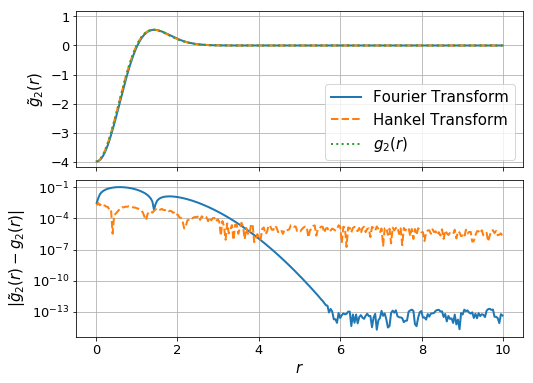

In [46]:
fig, ax = plt.subplots(2,1, sharex=True,gridspec_kw={"hspace":0.08},figsize=(8,6))

ax[0].plot(r_ft,g_ft, label="Fourier Transform", lw=2)
ax[0].plot(r_ht, g_ht, label="Hankel Transform", lw=2, ls='--')
ax[0].plot(r_ht, g(r_ht), label = "$g_2(r)$", lw=2, ls = ':')
ax[0].legend(fontsize=15)

#ax[0].xaxis.set_ticks([])
ax[0].grid(True)
ax[0].set_ylabel(r"$\tilde{g}_2(r)$",fontsize=15)
ax[0].set_ylim(-4.2,1.2)

ax[1].plot(r_ft, np.abs(g_ft-g(r_ft)), lw=2)
ax[1].plot(r_ht, np.abs(g_ht-g(r_ht)),lw=2, ls='--')
#ax[1].set_ylim(-1,1)
ax[1].set_yscale('log')
#ax[1].set_yscale("symlog",linthreshy=1e-6)
ax[1].set_ylabel(r"$|\tilde{g}_2(r)-g_2(r)|$",fontsize=15)
ax[1].set_xlabel(r"$r$",fontsize=15)
plt.grid(True)

if prefix:
    fig.savefig(path.join(prefix,"forward_laplacian.pdf"))

Timing for each calculation:

In [47]:
%timeit ft_transformation_2d(f,x_ft)
%timeit ht_transformation_nd(f,N_forward=Nforward, h_forward=hforward, N_back=Nback, h_back=hback, K = K, r = r_ht)

10 loops, best of 3: 19.9 ms per loop
10 loops, best of 3: 21.2 ms per loop


## Inverse Laplacian

We use the 1D Hankel (or 2D Fourier) transform to compute the Laplacian in three steps:
1. Compute the Forward Transform
    $$
    \mathcal{H}[g(r)] = \hat g(k)
    $$
2. Differentiate in Spectral space
    $$
    \hat f(k) = - \frac{1}{k^2} \hat g(k)
    $$
3. Compute the Inverse Transform
    $$
    f(r) = \mathcal{H}^{-1} [\hat f(k)]
    $$

Again, we compute the relevant Hankel parameters:

In [55]:
hback, res, Nback = get_h(fhat, nu=2, K=r_ht[::10], cls=SymmetricFourierTransform, atol=1e-8, rtol=1e-4, inverse=True)
K = np.logspace(-2, 2, N) # These values come from inspection of the plot above, which shows that ghat is ~zero outside these bounds
hforward, res, Nforward = get_h(g, nu=2, K=K[::50], cls=SymmetricFourierTransform, atol=1e-8, rtol=1e-4)
hforward,Nforward,hback,Nback

(4.8828125e-05, 3098, 0.000390625, 534)

In [52]:
## FT
r_ft, f_ft = ft_transformation_2d(g,x_ft, inverse=True)

# Note: r_ft is equivalent to r_ht

## HT
f_ht = ht_transformation_nd(g,N_forward=Nforward, h_forward=hforward,N_back=Nback, h_back=hback, K = K, r = r_ht, inverse=True)

/home/steven/anaconda2/envs/hankel/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in divide


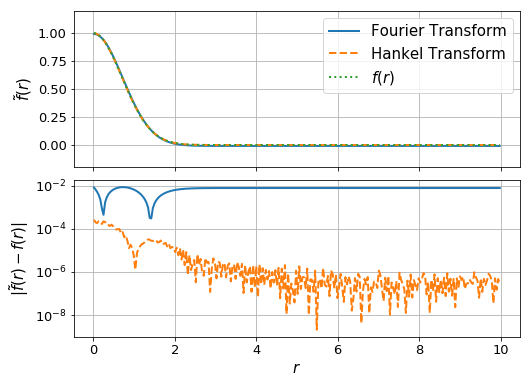

In [53]:
fig, ax = plt.subplots(2,1, sharex=True,gridspec_kw={"hspace":0.08},figsize=(8,6))

ax[0].plot(r_ft,f_ft, label="Fourier Transform", lw=2)
ax[0].plot(r_ht, f_ht, label="Hankel Transform", lw=2, ls='--')
ax[0].plot(r_ht, f(r_ht), label = "$f(r)$", lw=2, ls = ':')
ax[0].legend()

ax[0].grid(True)
ax[0].set_ylabel(r"$\tilde{f}(r)$",fontsize=15)
ax[0].set_ylim(-0.2,1.2)
#ax[0].set_yscale('log')

ax[1].plot(r_ft, np.abs(f_ft-f(r_ft)), lw=2)
ax[1].plot(r_ht, np.abs(f_ht-f(r_ht)),lw=2, ls='--')

ax[1].set_yscale('log')
ax[1].set_ylabel(r"$|\tilde{f}(r)-f(r)|$",fontsize=15)
ax[1].set_xlabel(r"$r$",fontsize=15)
plt.grid(True)

if prefix:
    fig.savefig(path.join(prefix,"inverse_laplacian.pdf"))

In [56]:
%timeit ft_transformation_2d(g,x_ft, inverse=True)
%timeit ht_transformation_nd(g,N_forward=Nforward, h_forward=hforward,N_back=Nback, h_back=hback, K = K, r = r_ht, inverse=True)

/home/steven/anaconda2/envs/hankel/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in divide


10 loops, best of 3: 20.5 ms per loop
10 loops, best of 3: 34.4 ms per loop


## 3D Problem (Forward)

We need to define the FT function again, for 3D:


In [57]:
def ft_transformation_3d(f,x, inverse=False):

    r = np.sqrt(np.sum(np.array(np.meshgrid(*([x]*3)))**2,axis=0))
    
    # Appropriate k-space values
    k = 2*np.pi*fftfreq(len(x),d=x[1]-x[0])
    K2 = np.sum(np.array(np.meshgrid(*([k]*3)))**2,axis=0)
    
    # The transformation
    if not inverse:
        g2d = ifftn(-K2 * fftn(f(r)).real).real
    else:
        invK2 = 1./K2
        invK2[np.isinf(invK2)] = 0.0
        
        g2d = ifftn(-invK2 * fftn(f(r)).real).real
        
    return x[len(x)/2:], g2d[len(x)/2,len(x)/2, len(x)/2:]

We also need to define the 3D laplacian function:

In [58]:
g3 = lambda r: 4.0*np.exp(-r**2)*(r**2 - 1.5)
fhat_3d = lambda x : np.pi**(3./2)*np.exp(-x**2/4.)
ghat_3d = lambda x : -x**2*fhat_3d(x)

In [59]:
L = 10.
N = 128
dr = L/N

x_ft = np.linspace(-L+dr/2,L-dr/2,2*N)
r_ht = np.linspace(dr/2,L-dr/2,N)

Again, choose our resolution parameters

In [71]:
hback, res, Nback = get_h(ghat_3d, nu=3, K=r_ht[::10], cls=SymmetricFourierTransform, atol=1e-8, rtol=1e-4, inverse=True)
K = np.logspace(-2, 2, 2*N) # These values come from inspection of the plot above, which shows that ghat is ~zero outside these bounds
hforward, res, Nforward = get_h(f, nu=3, K=K[::50], cls=SymmetricFourierTransform, atol=1e-8, rtol=1e-4)
hforward, Nforward, hback, Nback

(9.765625e-05, 2207, 0.00078125, 375)

In [64]:
## FT
r_ft, g_ft = ft_transformation_3d(f,x_ft)

# Note: r_ft is equivalent to r_ht

## HT
K = np.logspace(-1.0,2.,N)
g_ht = ht_transformation_nd(f,N_forward=Nforward, h_forward=hforward, N_back=Nback, h_back=hback, K = K, r = r_ht, ndim=3)

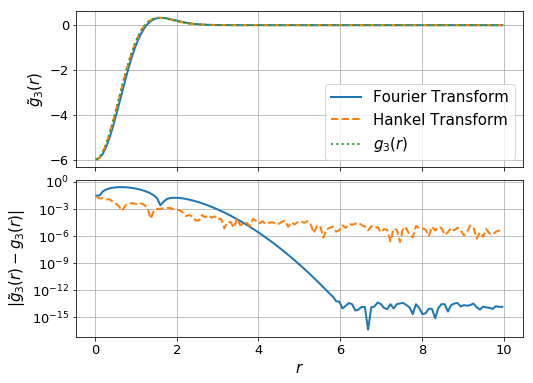

In [65]:
fig, ax = plt.subplots(2,1, sharex=True,gridspec_kw={"hspace":0.08},figsize=(8,6))

ax[0].plot(r_ft,g_ft, label="Fourier Transform", lw=2)
ax[0].plot(r_ht, g_ht, label="Hankel Transform", lw=2, ls='--')
ax[0].plot(r_ht, g3(r_ht), label = "$g_3(r)$", lw=2, ls = ':')
ax[0].legend(fontsize=15)

#ax[0].xaxis.set_ticks([])
ax[0].grid(True)
ax[0].set_ylabel(r"$\tilde{g}_3(r)$",fontsize=15)
#ax[0].set_ylim(-4.2,1.2)

ax[1].plot(r_ft, np.abs(g_ft-g3(r_ft)), lw=2)
ax[1].plot(r_ht, np.abs(g_ht-g3(r_ht)),lw=2, ls='--')

ax[1].set_yscale('log')
ax[1].set_ylabel(r"$|\tilde{g}_3(r)-g_3(r)|$",fontsize=15)
ax[1].set_xlabel(r"$r$",fontsize=15)
plt.grid(True)

if prefix:
    fig.savefig(path.join(prefix,"forward_laplacian_3D.pdf"))

In [72]:
%timeit ht_transformation_nd(f,N_forward=Nforward, h_forward=hforward, N_back=Nback, h_back=hback, K = K, r = r_ht, ndim=3)

%timeit ft_transformation_3d(f,x_ft)

100 loops, best of 3: 16.3 ms per loop
1 loop, best of 3: 2.66 s per loop


In [73]:
2.66/0.016

166.25